# Balance Checker

In [5]:
import os

# Paths to the label directories
folder_path_dir = '../dataset-main'
train_labels_dir = f'{folder_path_dir}/train/labels'
valid_labels_dir = f'{folder_path_dir}/valid/labels'

# Count the number of label files (assumes each .txt = one data point/image)
train_count = len([f for f in os.listdir(train_labels_dir) if f.endswith('.txt')])
valid_count = len([f for f in os.listdir(valid_labels_dir) if f.endswith('.txt')])
total = train_count + valid_count

# Calculate percentages
train_pct = (train_count / total) * 100 if total else 0
valid_pct = (valid_count / total) * 100 if total else 0

# Output results
print("---------------------------------------------------------")
print("📊 Dataset Split Summary")
print(f"Total data: {total}")
print(f"Train data: {train_count} ({train_pct:.2f}%)")
print(f"Valid data: {valid_count} ({valid_pct:.2f}%)")

# Check if it's approximately 80/20
if abs(train_pct - 80) <= 5 and abs(valid_pct - 20) <= 5:
    print("✅ The dataset is approximately balanced (80/20 split).")
else:
    print("⚠️ The dataset is NOT balanced (not 80/20 split).")


---------------------------------------------------------
📊 Dataset Split Summary
Total data: 19375
Train data: 15501 (80.01%)
Valid data: 3874 (19.99%)
✅ The dataset is approximately balanced (80/20 split).


# Value Checker

In [1]:
import os

folder_path_dir = '../dataset-main'
test_labels_dir = f'{folder_path_dir}/test/labels'
train_labels_dir = f'{folder_path_dir}/train/labels'
valid_labels_dir = f'{folder_path_dir}/valid/labels'

def extract_unique_class_ids(*dirs):
    unique_ids = set()
    for directory in dirs:
        if not os.path.exists(directory):
            print(f"Directory does not exist, skipping: {directory}")
            continue
        for filename in os.listdir(directory):
            if filename.endswith('.txt') and filename != 'classes.txt':
                file_path = os.path.join(directory, filename)
                with open(file_path, 'r') as file:
                    for line in file:
                        if line.strip():
                            class_id = line.strip().split()[0]
                            unique_ids.add(class_id)
    return unique_ids

# Safely include all label directories
unique_class_ids = extract_unique_class_ids(train_labels_dir, valid_labels_dir, test_labels_dir)

# Print all unique class IDs
for class_id in sorted(unique_class_ids, key=int):
    print(class_id)


0
1
2
3
4


# Value Changer

In [ ]:
import os

folder_path_dir = '../dataset-preprocess/landslide/combined'
test_labels_dir = f'{folder_path_dir}/test/labels'
train_labels_dir = f'{folder_path_dir}/train/labels'
valid_labels_dir = f'{folder_path_dir}/valid/labels'

# Define the class ID mappings
id_mapping = {
    # '0': '4',
    # '85': '2'
}

def update_class_ids_in_labels(*dirs):
    total_files_changed = 0  # Track the number of files changed
    for directory in dirs:
        if not os.path.exists(directory):
            print(f"Directory does not exist, skipping: {directory}")
            continue
        for filename in os.listdir(directory):
            if filename.endswith('.txt') and filename != 'classes.txt':  # Ignore classes.txt
                file_path = os.path.join(directory, filename)
                updated_lines = []
                file_changed = False  # Flag to check if any change was made in the file
                with open(file_path, 'r') as file:
                    for line in file:
                        if line.strip():
                            parts = line.strip().split()
                            if parts[0] in id_mapping:
                                parts[0] = id_mapping[parts[0]]
                                file_changed = True
                            updated_lines.append(' '.join(parts))
                
                if file_changed:
                    with open(file_path, 'w') as file:
                        for line in updated_lines:
                            file.write(line + '\n')
                    total_files_changed += 1

    return total_files_changed

# Apply the class ID updates
files_changed = update_class_ids_in_labels(train_labels_dir, valid_labels_dir, test_labels_dir)

# Print the number of files that were changed
print(f"Total number of .txt files edited/changed (excluding classes.txt): {files_changed}")


Total number of .txt files edited/changed (excluding classes.txt): 0


# Segmentation to Detection Points

In [69]:
import os

# Define directories
folder_path_dir = '../dataset-preprocess/landslide/combined'
label_dirs = {
    "train": f"{folder_path_dir}/train/labels",
    "valid": f"{folder_path_dir}/valid/labels",
    "test": f"{folder_path_dir}/test/labels"
}

def convert_seg_to_det(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        parts = list(map(float, line.strip().split()))
        if len(parts) <= 5:
            # Already a detection line
            new_lines.append(line)
            continue

        class_id = int(parts[0])
        # Extract polygon points (normalized)
        poly_points = parts[5:]
        xs = poly_points[::2]
        ys = poly_points[1::2]

        # Compute bounding box from polygon
        x_min, x_max = min(xs), max(xs)
        y_min, y_max = min(ys), max(ys)

        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min

        # Format: class x_center y_center width height
        new_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
        new_lines.append(new_line)

    with open(file_path, 'w') as f:
        f.writelines(new_lines)

# Process all label directories
for split, label_dir in label_dirs.items():
    if not os.path.exists(label_dir):
        print(f"Directory does not exist: {label_dir}")
        continue

    print(f"Processing {split} labels...")

    for filename in os.listdir(label_dir):
        if not filename.endswith('.txt') or filename == 'classes.txt':
            continue  # Skip non-txt and classes.txt
        file_path = os.path.join(label_dir, filename)
        convert_seg_to_det(file_path)

print("Conversion completed.")


Processing train labels...
Processing valid labels...
Processing test labels...
Conversion completed.


In [2]:
#cuda test
import torch
print(torch.version.cuda)           # Should NOT be None
print(torch.cuda.is_available())    # Should be True
print(torch.cuda.get_device_name(0))  # Should print 'GTX 1650'

11.8
True
NVIDIA GeForce GTX 1650


In [5]:
import subprocess
import sys
import os

# Define the path where the video will be saved
output_dir = "../test-videos"
os.makedirs(output_dir, exist_ok=True)

# Path to cookies file (adjust if needed)
cookies_file = "../youtube_cookies.txt"

while True:
    video_url = input("Enter the YouTube video URL (or 'exit' to quit): ")

    if video_url.lower() == 'exit':
        print("Exiting the download process.")
        break

    # Output path template with mp4 extension
    output_template = os.path.join(output_dir, "%(title)s.%(ext)s")

    try:
        subprocess.run([
            sys.executable, "-m", "yt_dlp",
            video_url,
            "-f", "bv*+ba/best",                 # Best video + best audio
            "--merge-output-format", "mp4",      # Merge and force output to .mp4
            "-o", output_template,
            "--progress",
            "--cookies", cookies_file
        ], check=True)
        print("Download completed successfully!")
    except subprocess.CalledProcessError as e:
        print(f"Download failed with return code {e.returncode}. Error message: {e}")
    except FileNotFoundError:
        print("yt-dlp is not installed. Please install it using 'pip install yt-dlp' and try again.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Download completed successfully!
Exiting the download process.


# Test Video and Save

In [8]:
import cv2
from ultralytics import YOLO

# Data
model_name = "cffl-6.3.11n-18.8k-100eph"  # Define the model name
model_path = f"../model/{model_name}.pt"
model = YOLO(model_path)
CONFIDENCE_THRESHOLD = 0.75
confidence_value = True  # Set to False to hide confidence values
confidence_value_name = True  # Set to True to show class name along with confidence

# video name and path
vidName = "vid1"
cap = cv2.VideoCapture(f"../test-videos/{vidName}.mp4")

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get the video's frame width, height, and FPS
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create a VideoWriter object to save the output
output_dir = "../test-result-videos"
output_file = f"{output_dir}/{model_name}_{vidName}_result.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)

    for result in results:
        mask = result.boxes.conf >= CONFIDENCE_THRESHOLD
        result.boxes = result.boxes[mask]

        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].int().tolist()
            conf = box.conf[0].item()
            cls_id = int(box.cls[0].item())
            class_name = result.names[cls_id] if cls_id in result.names else "Unknown"

            # Draw bounding box
            color = (0, 255, 0)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            # Label text
            label = ""
            if confidence_value_name:
                label = f"{class_name} {conf:.2f}" if confidence_value else f"{class_name}"
            elif confidence_value:
                label = f"{conf:.2f}"

            if label:
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    cv2.imshow("Video Detection", frame)
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()



0: 384x640 (no detections), 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.7ms
Speed: 0.0ms preprocess, 13.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 7.7ms
Speed: 4.6ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 15.8ms
Speed: 0.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 13.4ms
Speed: 0.0ms preprocess, 13.4ms inference, 2.0ms postprocess 

# Test Video

In [1]:
import cv2
from ultralytics import YOLO

DISPLAY_WIDTH = 1920
DISPLAY_HEIGHT = 1080

model_path = "../model/cffl-6.3.11n-18.8k-100eph.pt"
test_path = "../test-videos/vid1.mp4"
CONFIDENCE_THRESHOLD = 0.85

# Load the pre-trained model
model = YOLO(model_path)
# Open the video file
cap = cv2.VideoCapture(test_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Create a named window for display in resizable mode
cv2.namedWindow("Video Detection", cv2.WINDOW_NORMAL)

while True:
    # Read a frame from the video
    ret, frame = cap.read()
    
    # If the frame was read successfully
    if not ret:
        break
    
    # Perform object detection on the current frame
    results = model(frame)
    
    # Filter detections by confidence score
    for result in results:
        result.boxes = [box for box in result.boxes if box.conf[0] >= CONFIDENCE_THRESHOLD]

    # Get the annotated frame with bounding boxes
    annotated_frame = results[0].plot()
    
    # Resize the frame to match the display resolution
    resized_frame = cv2.resize(annotated_frame, (DISPLAY_WIDTH, DISPLAY_HEIGHT))
    
    # Display the resized frame in the window
    cv2.imshow("Video Detection", resized_frame)
    
    # Exit loop on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close any OpenCV windows
cap.release()
cv2.destroyAllWindows()



0: 384x640 (no detections), 86.7ms
Speed: 7.8ms preprocess, 86.7ms inference, 46.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 18.0ms
Speed: 2.6ms preprocess, 18.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 15.4ms
Speed: 2.3ms preprocess, 15.4ms inference, 84.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 14.2ms
Speed: 2.7ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 28.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 43.3ms
Speed: 4.3ms preprocess, 43.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 16.6ms
Speed: 3.5ms preprocess, 16.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 collision, 22.4ms
Speed: 2.9ms preprocess, 22.4ms inference, 1.9ms postp

# Metric Testing

In [9]:
from ultralytics import YOLO

def evaluate_model():
    model_path = "../model/cffl-6.3.11n-18.8k-100eph.pt"

    # Load the YOLOv8 segmentation model
    model = YOLO(model_path)

    # Evaluate model performance on the test set
    metrics = model.val(data="../data.yaml", task="segment")

    # Print metrics
    print(metrics)

if __name__ == '__main__':
    evaluate_model()


Ultralytics 8.3.74  Python-3.11.11 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\brian\Desktop\april-2025-model-training-main\dataset-main\valid\labels.cache... 3873 images, 255 backgrounds, 0 corrupt: 100%|██████████| 3874/3874 [00:00<?, ?it/s]

val: WARNING  C:\Users\brian\Desktop\april-2025-model-training-main\dataset-main\valid\images\00018_jpg.rf.48647aa240714dde706046ad774d581f.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\brian\Desktop\april-2025-model-training-main\dataset-main\valid\images\00018_jpg.rf.9f77fadb6dff6d6fd2045d4ebdf9bb2f.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\brian\Desktop\april-2025-model-training-main\dataset-main\valid\images\00019_jpg.rf.9e703f2310efb976e8a1da0a55604a03.jpg: 3 duplicate labels removed
val: WARNING  C:\Users\brian\Desktop\april-2025-model-training-main\dataset-main\valid\images\00019_jpg.rf.c4fa6043df0125cab405ef08cc8a7bca.jpg: 3 duplicate labels removed
val: WARNING  C:\Users\brian\Desktop\april-2025-model-training-main\dataset-main\valid\images\00098_jpg.rf.34fe09958f77e7c520b376c7599e94d0.jpg: 4 duplicate labels removed
val: WARNING  C:\Users\brian\Desktop\april-2025-model-training-main\dataset-main\valid\images\00098_jpg.rf.b98b1e675308f31a76cb4ecaf569c9b8.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 243/243 [00:43<00:00,  5.59it/s]


                   all       3874       6191      0.665      0.579      0.606      0.413
             collision       1249       1294      0.892      0.912      0.952       0.85
                  fire       1001       1883      0.742      0.637      0.719       0.33
                 smoke        783       1265      0.575      0.343      0.429      0.184
                 flood        750       1268      0.829      0.643      0.693      0.566
             landslide        370        481      0.286      0.358      0.237      0.137
Speed: 0.4ms preprocess, 5.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\segment\val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001912510F090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_res

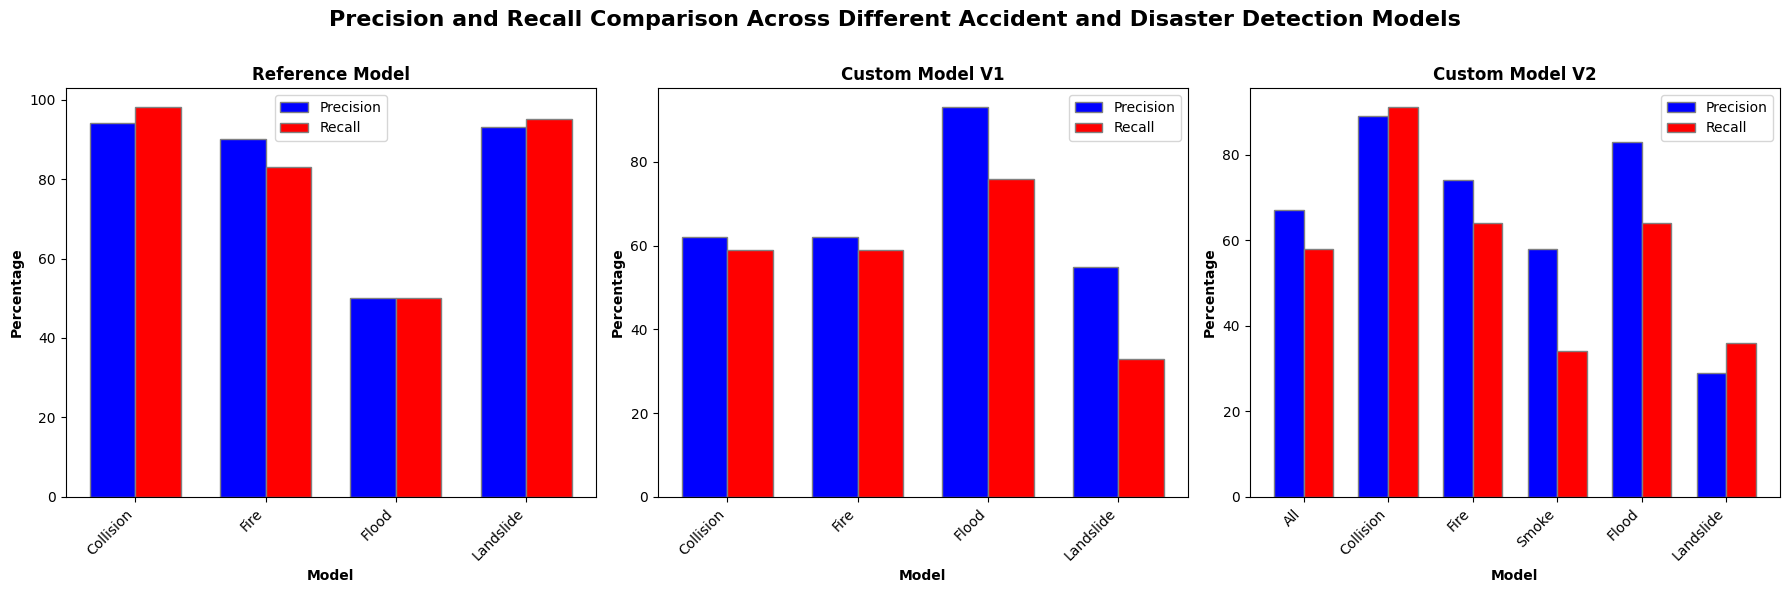

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each table

# Table 38 (Another Research)
models_38 = ['Collision', 'Fire', 'Flood', 'Landslide']
precision_38 = [94, 90, 50, 93]
recall_38 = [98, 83, 50, 95]

# Table 39 (Yolov11 Custom V1)
models_39 = ['Collision', 'Fire', 'Flood', 'Landslide']
precision_39 = [62, 62, 93, 55]
recall_39 = [59, 59, 76, 33]

# Table 39.5 (Yolov11 Custom V2)
models_39_5 = ['All', 'Collision', 'Fire', 'Smoke', 'Flood', 'Landslide']
precision_39_5 = [67, 89, 74, 58, 83, 29]
recall_39_5 = [58, 91, 64, 34, 64, 36]

# Set the width of the bars
bar_width = 0.35

# Set positions for the bars
r1_38 = np.arange(len(models_38))
r2_38 = [x + bar_width for x in r1_38]
r1_39 = np.arange(len(models_39))
r2_39 = [x + bar_width for x in r1_39]
r1_39_5 = np.arange(len(models_39_5))
r2_39_5 = [x + bar_width for x in r1_39_5]

# Create the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Table 38 Bar Plot
axes[0].bar(r1_38, precision_38, color='b', width=bar_width, edgecolor='grey', label='Precision')
axes[0].bar(r2_38, recall_38, color='r', width=bar_width, edgecolor='grey', label='Recall')
axes[0].set_xlabel('Model', fontweight='bold')
axes[0].set_ylabel('Percentage', fontweight='bold')
axes[0].set_title('Reference Model', fontweight='bold')
axes[0].set_xticks([r + bar_width / 2 for r in range(len(models_38))])
axes[0].set_xticklabels(models_38, rotation=45, ha='right')
axes[0].legend()

# Table 39 Bar Plot
axes[1].bar(r1_39, precision_39, color='b', width=bar_width, edgecolor='grey', label='Precision')
axes[1].bar(r2_39, recall_39, color='r', width=bar_width, edgecolor='grey', label='Recall')
axes[1].set_xlabel('Model', fontweight='bold')
axes[1].set_ylabel('Percentage', fontweight='bold')
axes[1].set_title('Custom Model V1', fontweight='bold')
axes[1].set_xticks([r + bar_width / 2 for r in range(len(models_39))])
axes[1].set_xticklabels(models_39, rotation=45, ha='right')
axes[1].legend()

# Table 39.5 Bar Plot
axes[2].bar(r1_39_5, precision_39_5, color='b', width=bar_width, edgecolor='grey', label='Precision')
axes[2].bar(r2_39_5, recall_39_5, color='r', width=bar_width, edgecolor='grey', label='Recall')
axes[2].set_xlabel('Model', fontweight='bold')
axes[2].set_ylabel('Percentage', fontweight='bold')
axes[2].set_title('Custom Model V2', fontweight='bold')
axes[2].set_xticks([r + bar_width / 2 for r in range(len(models_39_5))])
axes[2].set_xticklabels(models_39_5, rotation=45, ha='right')
axes[2].legend()

# Add a single title for all plots
fig.suptitle('Precision and Recall Comparison Across Different Accident and Disaster Detection Models', fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the main title
plt.show()


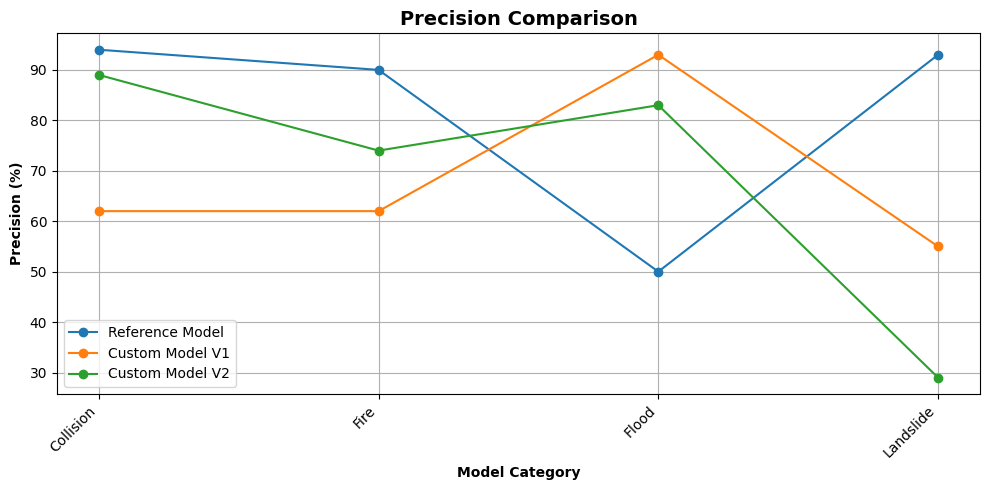

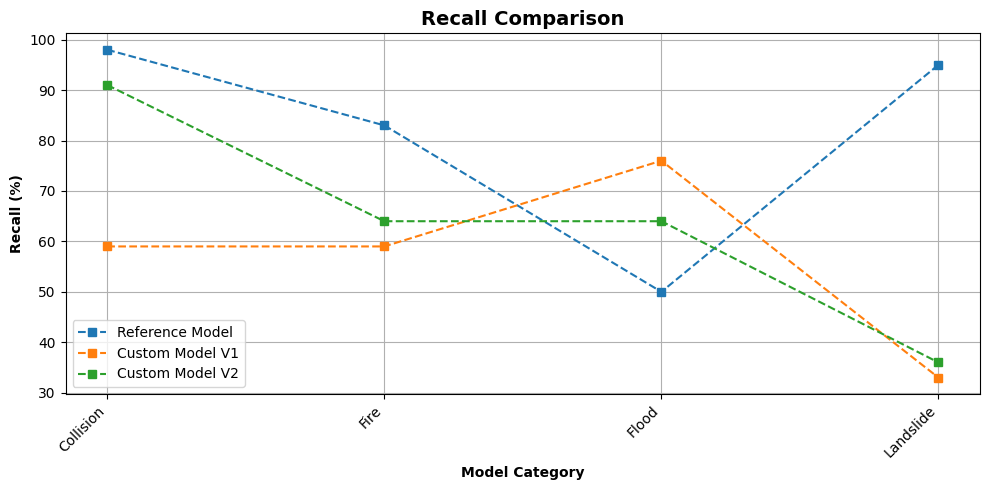

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Labels (common to all except 'Smoke' removed from V2)
labels_common = ['Collision', 'Fire', 'Flood', 'Landslide']

# Precision values
precision_38 = [94, 90, 50, 93]
precision_39 = [62, 62, 93, 55]
precision_39_5 = [89, 74, 83, 29]  # Excluding "All" and "Smoke"

# Recall values
recall_38 = [98, 83, 50, 95]
recall_39 = [59, 59, 76, 33]
recall_39_5 = [91, 64, 64, 36]  # Excluding "All" and "Smoke"

# X-axis
x = np.arange(len(labels_common))

# ---------- Precision Plot ----------
plt.figure(figsize=(10, 5))
plt.plot(x, precision_38, marker='o', label='Reference Model')
plt.plot(x, precision_39, marker='o', label='Custom Model V1')
plt.plot(x, precision_39_5, marker='o', label='Custom Model V2')
plt.xticks(x, labels_common, rotation=45, ha='right')
plt.title('Precision Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Model Category', fontweight='bold')
plt.ylabel('Precision (%)', fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Recall Plot ----------
plt.figure(figsize=(10, 5))
plt.plot(x, recall_38, marker='s', linestyle='--', label='Reference Model')
plt.plot(x, recall_39, marker='s', linestyle='--', label='Custom Model V1')
plt.plot(x, recall_39_5, marker='s', linestyle='--', label='Custom Model V2')
plt.xticks(x, labels_common, rotation=45, ha='right')
plt.title('Recall Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Model Category', fontweight='bold')
plt.ylabel('Recall (%)', fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


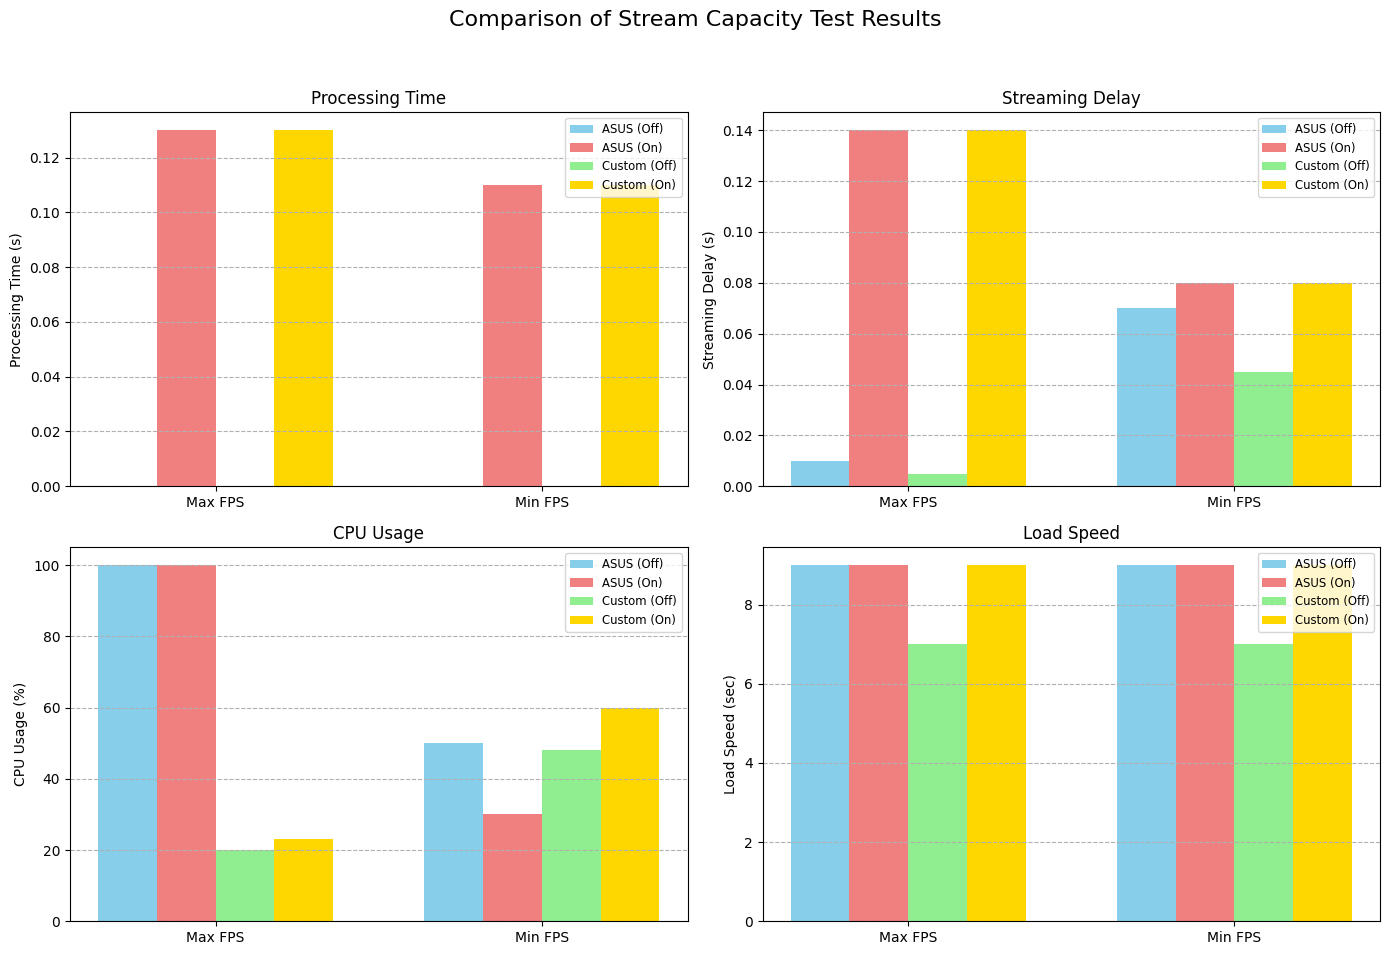

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data from Table 35 (ASUS ROG Strix G15 G513)
fps_asus_off = [25, 13]
processing_time_asus_off = [0.000] * 2
streaming_delay_asus_off = [0.010, 0.070]
load_speed_asus_off = [9] * 2
cpu_usage_asus_off = [100, 50]
model_status_asus_off = ['Off'] * 2

fps_asus_on = [15, 8]
processing_time_asus_on = [0.130, 0.110]
streaming_delay_asus_on = [0.140, 0.080]
load_speed_asus_on = [9] * 2
cpu_usage_asus_on = [100, 30]
model_status_asus_on = ['On'] * 2

# Data from Table 36 (Customized PC)
fps_custom_off = [25, 13]
processing_time_custom_off = [0.000] * 2
streaming_delay_custom_off = [0.005, 0.045]
load_speed_custom_off = [7] * 2
cpu_usage_custom_off = [20, 48]
model_status_custom_off = ['Off'] * 2

fps_custom_on = [15, 8]
processing_time_custom_on = [0.130, 0.110]
streaming_delay_custom_on = [0.140, 0.080]
load_speed_custom_on = [9] * 2
cpu_usage_custom_on = [23, 60]
model_status_custom_on = ['On'] * 2

# Define categories and groups
categories = ['Max FPS', 'Min FPS']
groups = ['ASUS (Off)', 'ASUS (On)', 'Custom (Off)', 'Custom (On)']
x = np.arange(len(categories))
width = 0.18  # Narrower bars for better separation

# Colors for each group
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparison of Stream Capacity Test Results', fontsize=16)

# Plot for Processing Time
axs[0, 0].bar(x - 1.5*width, processing_time_asus_off, width, label=groups[0], color=colors[0])
axs[0, 0].bar(x - 0.5*width, processing_time_asus_on, width, label=groups[1], color=colors[1])
axs[0, 0].bar(x + 0.5*width, processing_time_custom_off, width, label=groups[2], color=colors[2])
axs[0, 0].bar(x + 1.5*width, processing_time_custom_on, width, label=groups[3], color=colors[3])
axs[0, 0].set_ylabel('Processing Time (s)')
axs[0, 0].set_title('Processing Time')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(categories)
axs[0, 0].legend(fontsize='small')
axs[0, 0].grid(axis='y', linestyle='--')

# Plot for Streaming Delay
axs[0, 1].bar(x - 1.5*width, streaming_delay_asus_off, width, label=groups[0], color=colors[0])
axs[0, 1].bar(x - 0.5*width, streaming_delay_asus_on, width, label=groups[1], color=colors[1])
axs[0, 1].bar(x + 0.5*width, streaming_delay_custom_off, width, label=groups[2], color=colors[2])
axs[0, 1].bar(x + 1.5*width, streaming_delay_custom_on, width, label=groups[3], color=colors[3])
axs[0, 1].set_ylabel('Streaming Delay (s)')
axs[0, 1].set_title('Streaming Delay')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(categories)
axs[0, 1].legend(fontsize='small')
axs[0, 1].grid(axis='y', linestyle='--')

# Plot for CPU Usage
axs[1, 0].bar(x - 1.5*width, cpu_usage_asus_off, width, label=groups[0], color=colors[0])
axs[1, 0].bar(x - 0.5*width, cpu_usage_asus_on, width, label=groups[1], color=colors[1])
axs[1, 0].bar(x + 0.5*width, cpu_usage_custom_off, width, label=groups[2], color=colors[2])
axs[1, 0].bar(x + 1.5*width, cpu_usage_custom_on, width, label=groups[3], color=colors[3])
axs[1, 0].set_ylabel('CPU Usage (%)')
axs[1, 0].set_title('CPU Usage')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(categories)
axs[1, 0].legend(fontsize='small')
axs[1, 0].grid(axis='y', linestyle='--')

# Plot for Load Speed
load_asus_off = [9, 9]
load_asus_on = [9, 9]
load_custom_off = [7, 7]
load_custom_on = [9, 9]

axs[1, 1].bar(x - 1.5*width, load_asus_off, width, label=groups[0], color=colors[0])
axs[1, 1].bar(x - 0.5*width, load_asus_on, width, label=groups[1], color=colors[1])
axs[1, 1].bar(x + 0.5*width, load_custom_off, width, label=groups[2], color=colors[2])
axs[1, 1].bar(x + 1.5*width, load_custom_on, width, label=groups[3], color=colors[3])
axs[1, 1].set_ylabel('Load Speed (sec)')
axs[1, 1].set_title('Load Speed')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(categories)
axs[1, 1].legend(fontsize='small')
axs[1, 1].grid(axis='y', linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Rename Image and Labels names

In [1]:
import os

# Define paths
paths = {
    "train_images": "../dataset-main/train/images",
    "test_images": "../dataset-main/test/images",
    "valid_images": "../dataset-main/valid/images",
    "train_labels": "../dataset-main/train/labels",
    "test_labels": "../dataset-main/test/labels",
    "valid_labels": "../dataset-main/valid/labels",
}

# Function to rename image and label files together, ignoring classes.txt
def rename_images_and_labels(image_folder, label_folder, prefix, image_extension=".jpg", label_extension=".txt"):
    if not os.path.exists(image_folder):
        print(f"Skipped: Image folder not found - {image_folder}")
        return
    if not os.path.exists(label_folder):
        print(f"Skipped: Label folder not found - {label_folder}")
        return

    image_files = sorted(os.listdir(image_folder))
    label_files = sorted(os.listdir(label_folder))

    count = 1
    for image_file, label_file in zip(image_files, label_files):
        if image_file == "classes.txt" or label_file == "classes.txt":
            continue

        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, label_file)

        if os.path.isfile(image_path) and os.path.isfile(label_path) and not image_file.startswith('.') and not label_file.startswith('.'):
            image_ext = os.path.splitext(image_file)[1]
            label_ext = os.path.splitext(label_file)[1]

            if image_ext != image_extension or label_ext != label_extension:
                continue

            new_image_name = f"{prefix}{count}{image_extension}"
            new_label_name = f"{prefix}{count}{label_extension}"

            os.rename(image_path, os.path.join(image_folder, new_image_name))
            os.rename(label_path, os.path.join(label_folder, new_label_name))

            print(f"Renamed: {image_file} -> {new_image_name}")
            print(f"Renamed: {label_file} -> {new_label_name}")

            count += 1

# Rename image and label files for each set
rename_images_and_labels(paths["train_images"], paths["train_labels"], "train", ".jpg", ".txt")
rename_images_and_labels(paths["test_images"], paths["test_labels"], "test", ".jpg", ".txt")
rename_images_and_labels(paths["valid_images"], paths["valid_labels"], "valid", ".jpg", ".txt")


Renamed: --------12_mp4-37_jpg.rf.3b6b50c12ea071182d6dc77e6fca6ec2.jpg -> train1.jpg
Renamed: --------12_mp4-37_jpg.rf.3b6b50c12ea071182d6dc77e6fca6ec2.txt -> train1.txt
Renamed: --------12_mp4-37_jpg.rf.41e3279bb3135749d965f36ebaad8c9b.jpg -> train2.jpg
Renamed: --------12_mp4-37_jpg.rf.41e3279bb3135749d965f36ebaad8c9b.txt -> train2.txt
Renamed: --------12_mp4-37_jpg.rf.4e85859c821ba6ab7197153011222c51.jpg -> train3.jpg
Renamed: --------12_mp4-37_jpg.rf.4e85859c821ba6ab7197153011222c51.txt -> train3.txt
Renamed: --------12_mp4-37_jpg.rf.7004b6045d3fb06c95b79f0e8c02f2ce.jpg -> train4.jpg
Renamed: --------12_mp4-37_jpg.rf.7004b6045d3fb06c95b79f0e8c02f2ce.txt -> train4.txt
Renamed: --------12_mp4-37_jpg.rf.a6304cef6a00c7f9f36d823e00ba98d1.jpg -> train5.jpg
Renamed: --------12_mp4-37_jpg.rf.a6304cef6a00c7f9f36d823e00ba98d1.txt -> train5.txt
Renamed: --------12_mp4-37_jpg.rf.e3b12271ea5dce4393144e62f9cd9f16.jpg -> train6.jpg
Renamed: --------12_mp4-37_jpg.rf.e3b12271ea5dce4393144e62f9cd9f1